# Predict the online shoppers' intentions

The dataset used for this project is the [Online Shoppers Purchasing Intention Dataset](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset#) from UCI.

In [0]:
# Install libraries
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install eli5
    !pip install pdpbox

In [0]:
# Read data
import pandas as pd
url = 'https://raw.githubusercontent.com/doinalangille/Online-shoppers-intention/master/assets/online_shoppers_intention.csv'
df = pd.read_csv(url)

The target is the `Revenue`, boolean variable, which represents the intention of shopper. True means the shopping session ended with purchase, and False means the purchase did not happen.

In [76]:
df['Revenue'].value_counts(normalize=True)

False    0.845255
True     0.154745
Name: Revenue, dtype: float64

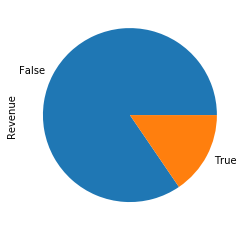

In [73]:
result = df['Revenue'].value_counts(normalize=True)
result.plot(kind='pie');

The main task of the project is to **predict the intention of purchase**. It is a **classification problem**, where the target has **two classes** (True or False), and the **classes are imbalanced**: the False value occurs with 84.5% frequency.

It's more important to correctly predict the positive class, whose frequency is smaller than the negative class, so I will use the **Area Under the Receiver Operating Characteristic Curve (ROC AUC) as evaluation metrics**

In [4]:
# Get Profiling Report for the dataset
from pandas_profiling import ProfileReport
profile = ProfileReport(df, minimal=True).to_notebook_iframe()
profile

Important [dataset information provided by UCI](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset#):

The dataset was formed so that each session would belong to a different user in a 1-year period to avoid any tendency to a specific campaign, special day, user
profile, or period.

The following variables represent the number of different types of pages visited by the visitor in that session and total time spent in each of these page categories. The values of these features are derived from the URL information of the pages visited by the user and updated in real time when a user takes an action, e.g. moving from one page to another: 

**- "Administrative"** 

**- "Administrative Duration"** 

**- "Informational"**

**- "Informational Duration"**

**- "Product Related"** 

**- "Product Related Duration"**

**"Bounce Rate"**: the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session. 

**"Exit Rate"**: the percentage that were the last in the session. 

**"Page Value"**: the average value for a web page that a user visited before completing an e-commerce transaction. 

**"Special Day"**: the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date. For example, for Valentine’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8.

**"Visitor type"**: returning or new visitor, 

**"Weekend"**: a Boolean value indicating whether the date of the visit is weekend


In [0]:
# The dataset contains 125 duplicate rows
# Keep only one unique row
df.drop_duplicates(keep='first', inplace=True)

# Delete outliers - the last 35% for 'ProductRelated_Duration and the last 1% for other variables 
cols = ['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'PageValues']

for c in cols:
  if (c=='ProductRelated_Duration'):
    condition = df[c] <= (max(df[c]) - max(df[c])*0.35)
    df = df[condition]
  else:
    condition = df[c] <= (max(df[c]) - max(df[c])*0.01)
    df = df[condition]

In [78]:
# Split the data into train/validate/test
# Use random split, because data is provided for just one year, and it is possible to lose valuable insights if splitting by month

# Split dataframe into train & test
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df['Revenue'], random_state=42)
# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['Revenue'], random_state=42)

train.shape, val.shape, test.shape

((7433, 18), (1859, 18), (2324, 18))

The variable **"Special Day"** is the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date. For example, for Valentine’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8.

In [0]:
# Define a function to wrangle the data sets in the same way
import numpy as np

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()

    # The dataset contains 125 duplicate rows
    # Keep only one unique row
    X.drop_duplicates(keep='first', inplace=True)

    # Convert Boolean variables into dummy variables with 1 and 0
    # 1 == True, 0 == False
    X['Revenue'] = X['Revenue'].astype(int)
    X['Weekend'] = X['Weekend'].astype(int)

    # Make a new feature to group all the scores based on either it was or not close to a holiday
    X['HolidayPeriod'] = np.where(X['SpecialDay']==0, 0, 1)

    # Some variables have to be categorical, not numerical
    # Transform them into strings
    cols_to_string = ['SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']
    for c in cols_to_string:
      X[c] = X[c].astype(str)

    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

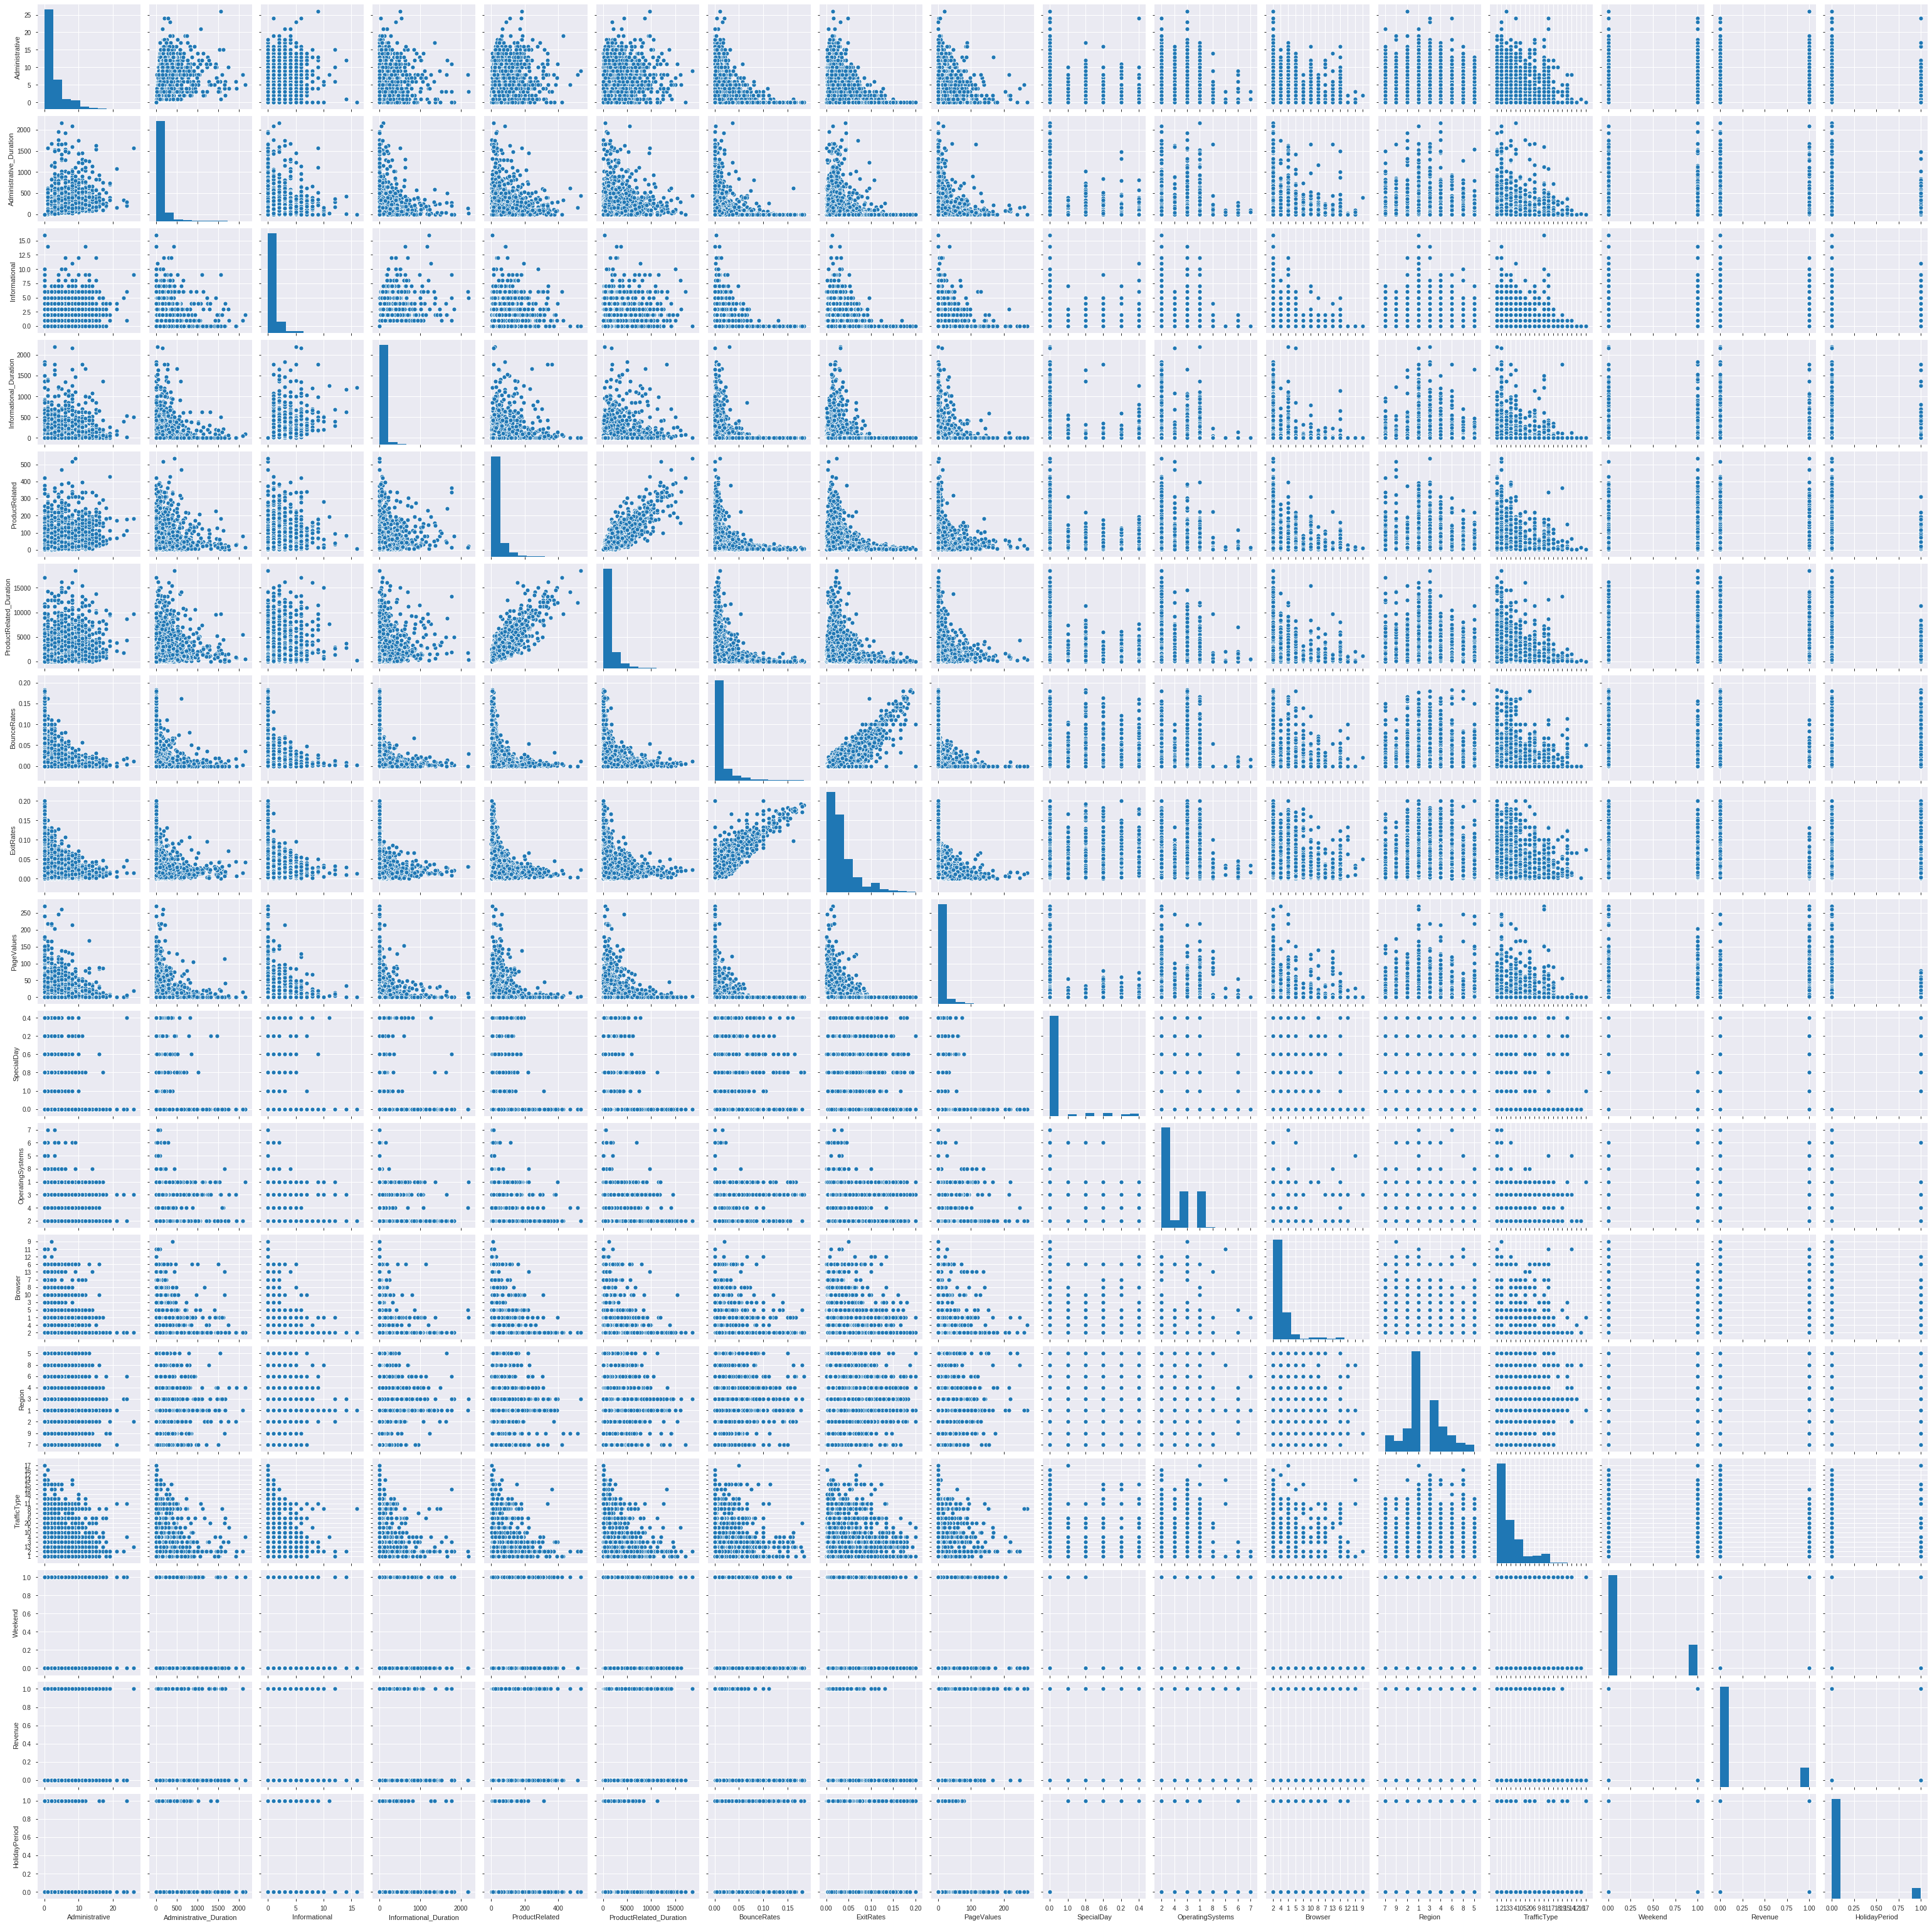

In [8]:
# Display the relationship between numerical variables
import seaborn as sns
sns.pairplot(train);

### Baselines for classification

In [80]:
# My target to predict is Revenue
# Determine the majority class
train['Revenue'].value_counts(normalize=True)

0    0.836271
1    0.163729
Name: Revenue, dtype: float64

In [81]:
# What is the majority class for every prediction?
y_train = train['Revenue']
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)
pd.unique(y_pred), len(y_pred)

(array([0]), 7433)

In [82]:
# Get validation recall and precision for the baseline for classification
from sklearn.metrics import roc_auc_score

y_val = val['Revenue']
y_pred = [majority_class] * len(val)

print("ROC AUC Score:", roc_auc_score(y_val, y_pred))

ROC AUC Score: 0.5


### Logistic Regression

In [0]:
import category_encoders as ce
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

# Arrange data into X features matrix and y target vector
target = 'Revenue'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)
y_test = test[target]

# Encode the categorical variables
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)

In [84]:
# Apply the Logistic Regression
import sklearn.metrics
model = LogisticRegressionCV()
model.fit(X_train_scaled, y_train)

y_pred_proba = model.predict_proba(X_val_scaled)[:,1]
print("ROC AUC Score:", roc_auc_score(y_val, y_pred_proba))

ROC AUC Score: 0.8827360805550855


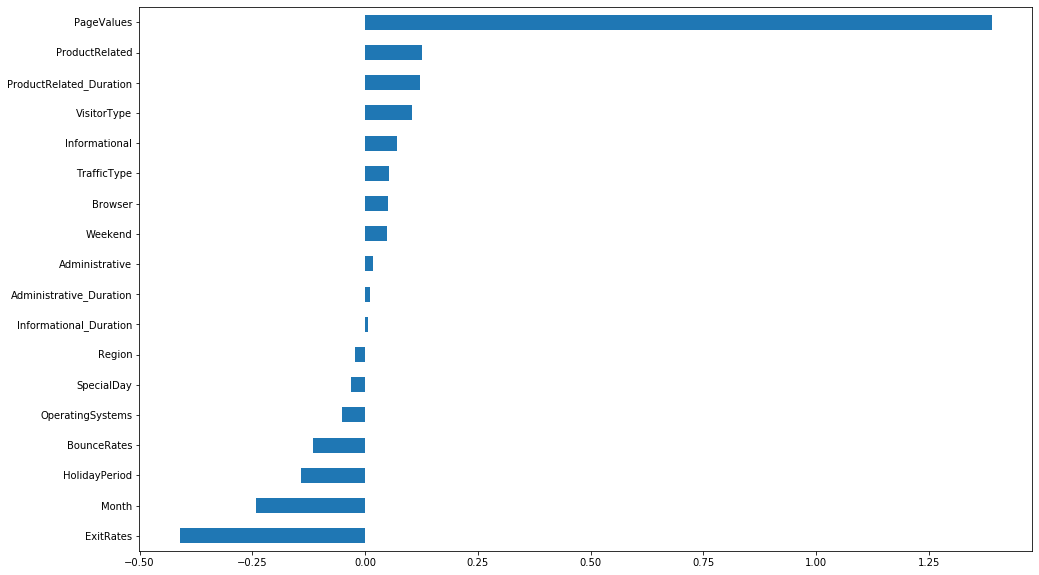

In [85]:
# Plot the coefficients:
import matplotlib.pyplot as plt
%matplotlib inline
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
plt.figure(figsize=(16,10))
coefficients.sort_values().plot.barh();

### First classification model

In [86]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

# Make pipeline!
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
y_pred_proba = pipeline.predict_proba(X_val)[:,1]

# Get ROC AUC Score
print("ROC AUC Score:", roc_auc_score(y_val, y_pred_proba))

ROC AUC Score: 0.9178943137586733


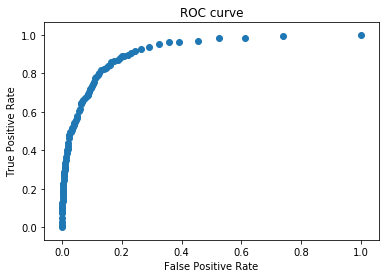

In [87]:
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(y_val, y_pred_proba)

# See the results on a plot. 
# This is the "Receiver Operating Characteristic" curve
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

### Second classification model

In [88]:
# Optimize 3+ hyperparameters by trying 10+ candidates
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier(random_state=42)
)

param_distributions = {
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], 
    'randomforestclassifier__max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=3, 
    scoring='roc_auc', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.1min finished


In [89]:
print('Best hyperparameters', search.best_params_)

Best hyperparameters {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 0.4867880206427604, 'randomforestclassifier__n_estimators': 225}


In [90]:
# Make predictions for validation set
pipeline = search.best_estimator_
y_pred = pipeline.predict(X_val)
y_pred_proba = pipeline.predict_proba(X_val)[:,1]

# Get ROC AUC Score
print("ROC AUC Score:", roc_auc_score(y_val, y_pred_proba))

ROC AUC Score: 0.9251015400236927


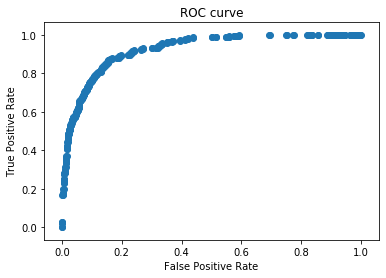

In [17]:
# See the results on a plot. 
fpr, tpr, threshold = roc_curve(y_val, y_pred_proba)

plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

### Try xgboost

In [18]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
y_pred_proba = pipeline.predict_proba(X_val)[:,1]

# Get ROC AUC Score
print("ROC AUC Score:", roc_auc_score(y_val, y_pred_proba))

ROC AUC Score: 0.9261127094262989


In [19]:
# fit_transfom on train, transform on val
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = XGBClassifier(
    n_estimators=1000,  
    max_depth=7,        
    learning_rate=0.5,  
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          eval_metric='error', 
          early_stopping_rounds=10) 

[0]	validation_0-error:0.076954	validation_1-error:0.122109
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.070496	validation_1-error:0.11135
[2]	validation_0-error:0.066191	validation_1-error:0.11135
[3]	validation_0-error:0.063232	validation_1-error:0.110274
[4]	validation_0-error:0.057177	validation_1-error:0.109198
[5]	validation_0-error:0.052469	validation_1-error:0.109736
[6]	validation_0-error:0.048433	validation_1-error:0.110274
[7]	validation_0-error:0.047356	validation_1-error:0.109736
[8]	validation_0-error:0.043993	validation_1-error:0.109736
[9]	validation_0-error:0.041437	validation_1-error:0.107585
[10]	validation_0-error:0.041033	validation_1-error:0.109198
[11]	validation_0-error:0.039957	validation_1-error:0.109198
[12]	validation_0-error:0.039284	validation_1-error:0.108661
[13]	validation_0-error:0.037535	validation_1-error:0.1097

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

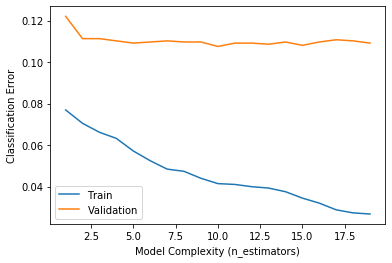

In [20]:
results = model.evals_result()
train_error = results['validation_0']['error']
val_error = results['validation_1']['error']
epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.legend();

In [21]:
y_pred_proba = model.predict_proba(X_val_encoded)[:,1]

# Get ROC AUC Score
print("ROC AUC Score:", roc_auc_score(y_val, y_pred_proba))

ROC AUC Score: 0.9226740988322898


# Select the best model

The second model, using RandomizedCV(), is the most performant. I will continue my analysis using this model.

In [91]:
# Run again the model
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestClassifier(max_depth=5, max_features=0.7164353684966558, n_estimators=460, random_state=42, n_jobs=-1)
)

# Fit on train
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['SpecialDay', 'Month', 'OperatingSystems',
                                      'Browser', 'Region', 'TrafficType',
                                      'VisitorType'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'SpecialDay',
                                          'data_type': dtype('O'),
                                          'mapping': 0.0    1
1.0    2
0.8    3
0.6    4
0.2    5
0.4    6
NaN   -2
dtype: int64},
                                         {'col': 'Month',
                                          'data_typ...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=5,
                         

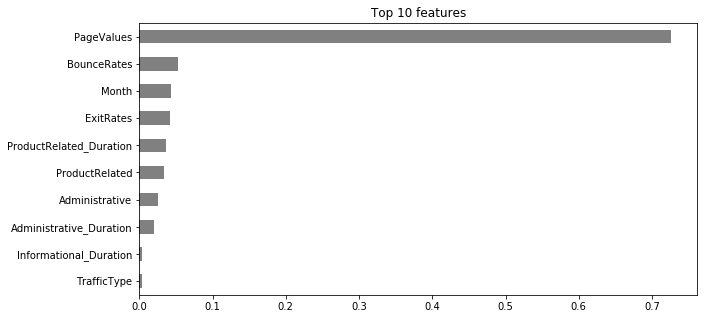

In [92]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [93]:
# Use eli5 to get permutation importances
import eli5
from eli5.sklearn import PermutationImportance

# Run the model
transformers = make_pipeline(
    ce.OrdinalEncoder())

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(max_depth=5, max_features=0.7164353684966558, n_estimators=460, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

# 1. Calculate permutation importances
permuter = PermutationImportance(
    model, 
    scoring='roc_auc', 
    n_iter=10, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

# 2. Display permutation importances
feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter, 
    top=None, 
    feature_names=feature_names 
)

In [94]:
# Include only important features in the model
target = 'Revenue'
features = ['PageValues', 'Month', 'BounceRates', 'ExitRates', 'Administrative', 'Administrative_Duration', 'ProductRelated', 'ProductRelated_Duration']
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestClassifier(max_depth=5, max_features=0.7164353684966558, n_estimators=460, random_state=42, n_jobs=-1)
)

# Fit on train
pipeline.fit(X_train, y_train)

# Make predictions for the val set
y_pred = pipeline.predict(X_val)
y_pred_proba = pipeline.predict_proba(X_val)[:,1]

# Get ROC AUC Score for the val set
print("ROC AUC Score for the val set:", roc_auc_score(y_val, y_pred_proba))

ROC AUC Score for the val set: 0.9255880859705534


In [95]:
# Get ROC AUC score for the test set
X_test = test[features]
y_test = test[target]

y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:,1]

print("ROC AUC Score for the test set:", roc_auc_score(y_test, y_pred_proba))

ROC AUC Score for the test set: 0.9308581059129305


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


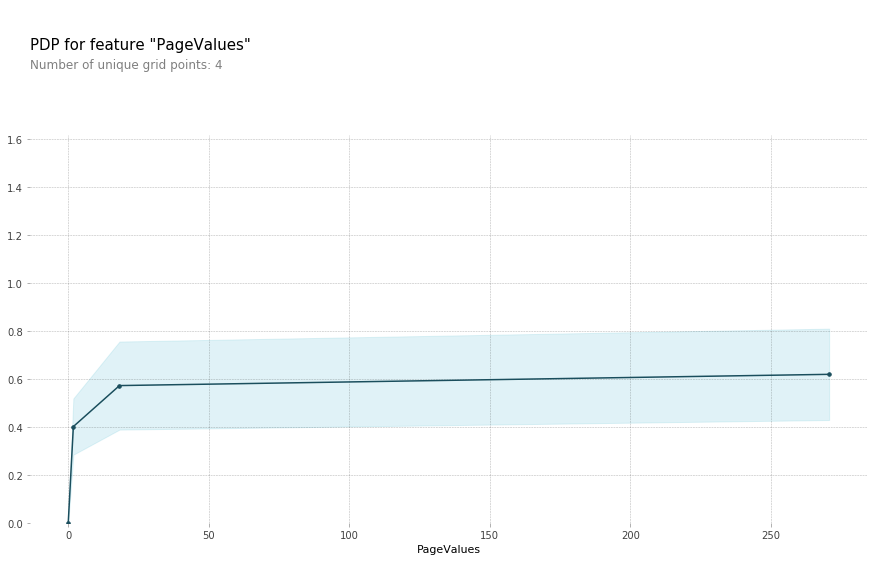

In [98]:
# Display Partial Dependence Plot
from pdpbox import pdp
#Run the model
features = ['PageValues', 'Month', 'BounceRates', 'ExitRates', 'Administrative', 'Administrative_Duration', 'ProductRelated', 'ProductRelated_Duration']
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
model = RandomForestClassifier(max_depth=5, max_features=0.7164353684966558, n_estimators=460, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)

# Plot the partial dependence
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_train_encoded, model_features=features, feature='PageValues')
pdp.pdp_plot(pdp_dist, 'PageValues');

# Prepare the Dash App

In [36]:
# Create pipeline.joblib file
from joblib import dump
dump(pipeline, 'pipeline.joblib', compress=True)

['pipeline.joblib']

In [0]:
# Download the file
from google.colab import files
files.download('pipeline.joblib')

In [25]:
# Get version of libraries
import joblib
import sklearn
import category_encoders as ce
import xgboost
print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'category_encoders=={ce.__version__}')
print(f'xgboost=={xgboost.__version__}')

joblib==0.14.1
scikit-learn==0.22.1
category_encoders==2.1.0
xgboost==0.90


In [46]:
# Run the model again
target = 'Revenue'
features = ['PageValues', 'Month', 'BounceRates', 'ExitRates', 'Administrative', 'Administrative_Duration', 'ProductRelated', 'ProductRelated_Duration']
X_train = train[features]
y_train = train[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestClassifier(max_depth=5, max_features=0.7164353684966558, n_estimators=460, random_state=42, n_jobs=-1)
)

# Fit on train
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Month'], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[{'col': 'Month',
                                          'data_type': dtype('O'),
                                          'mapping': Nov      1
Oct      2
May      3
Mar      4
June     5
Dec      6
Aug      7
Jul      8
Sep      9
Feb     10
NaN     -2
dtype: int64}],
                                return_df=True, verbose=0)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=Tru...cp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=5,
                                        max_features=0.7164353684966558,
                                        max_leaf_nodes=None, max_samples=None,
                      

In [0]:
# Define predict function
def predict(page_values, month, bounce_rates, exit_rates, administrative, administrative_duration, product_related, product_related_duration):
    data = pd.DataFrame(
        columns=['PageValues', 'Month', 'BounceRates', 'ExitRates', 'Administrative', 'Administrative_Duration', 'ProductRelated', 'ProductRelated_Duration'], 
        data=[[page_values, month, bounce_rates, exit_rates, administrative, administrative_duration, product_related, product_related_duration]]
    )
    y_pred = pipeline.predict(data)[0]
    y_pred_proba = pipeline.predict_proba(data)[:,y_pred]
    probability = y_pred_proba*100
    if y_pred==1:
      result = 'buy'
    else:
      result = 'not buy'
    return f'There is a probability of {probability[0]:.2f}% that the user will {result} an item'

In [67]:
predict(14, 'June', 0.2, 0.2, 2, 2, 1, 1)

'There is a probability of 50.79% that the user will not buy an item'